In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
import generate_1d, geometry_util, decode_detect_1d

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device {}".format(device))

using device cuda


First, generate some synthetic ring data

In [3]:
encoder, decoder, _ = generate_1d.train(n_circular_dimensions=1, n_linear_dimensions=0, embedding_dimension=12, device=device, n_training_iterations=3000)

/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 1.7181094884872437, distance cost: 0.010129813104867935
iteration: 3, decoding loss: 1.3584846258163452, distance cost: 0.027300281450152397
iteration: 4, decoding loss: 1.0908011198043823, distance cost: 0.022371705621480942
iteration: 5, decoding loss: 0.7391132116317749, distance cost: 0.024340936914086342
iteration: 6, decoding loss: 0.6072192788124084, distance cost: 0.04162684828042984
iteration: 7, decoding loss: 0.48397958278656006, distance cost: 0.05837942659854889
iteration: 14, decoding loss: 0.3973776698112488, distance cost: 0.0661940649151802
iteration: 15, decoding loss: 0.3169137239456177, distance cost: 0.06473943591117859
iteration: 16, decoding loss: 0.29905813932418823, distance cost: 0.05559578165411949
iteration: 28, decoding loss: 0.292437881231308, distance cost: 0.026694945991039276
iteration: 29, decoding loss: 0.256559818983078, distance cost: 0.025850148871541023
iteration: 30, decoding loss: 0.22242748737335205, distance cost: 

In [4]:
angles = np.arange(start=0, stop=2 * np.pi, step=0.01)
with torch.no_grad():
    ring_embedded_points = encoder(torch.tensor(np.expand_dims(angles, -1), dtype=torch.get_default_dtype()).to(device))
ring_embedded_points = ring_embedded_points.cpu().numpy()

In [5]:
ring_embedded_points = ring_embedded_points/np.mean(np.abs(ring_embedded_points))

Now we will detect the dimension of and decode the ring data we just generated. The below code looks for the best manifold of dimension max_n_dimensions or less and fits it.

In [6]:
import importlib
max_n_dimensions = 4
importlib.reload(decode_detect_1d)
encoder, decoder, geometry_profile = decode_detect_1d.train(ring_embedded_points, max_n_dimensions, 0, device, decoder_weight=10, scrambling_weight=1, order_red_weight=1, n_training_iterations=15000)


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 1.3030712604522705, distance cost: 0.010805509984493256, order reduction: 0.007343966048210859, scrambling weights: tensor([0.0180, 0.0180, 0.0180, 0.0180], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
iteration: 3, decoding loss: 0.2433193176984787, distance cost: 0.01240258663892746, order reduction: 0.002916258992627263, scrambling weights: tensor([0.0180, 0.0180, 0.0180, 0.0180], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
iteration: 6, decoding loss: 0.1872463822364807, distance cost: 0.019528863951563835, order reduction: 0.0037561391945928335, scrambling weights: tensor([0.0180, 0.0180, 0.0181, 0.0180], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
iteration: 7, decoding loss: 0.14163383841514587, distance cost: 0.01062681246548891, order reduction: 0.0033924251329153776, scrambling weights: tensor([0.0180, 0.0180, 0.0181, 0.0180], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
iteration: 11, decoding loss: 0.108378663659095

The last return of this function, geometry_profile, contains the optimized value of scrambling_weights. If training worked, this should be close to 1 everywhere except for one index, which should be close to zero. This means the training process identified the fact that the underlying manifold had only one dimension. The index of the near-zero element, the "primary dimension" is the dimension we should use to address the 1D manifold.

In [7]:
geometry_profile = geometry_profile.cpu().detach().numpy()

In [8]:
used_dimension = np.argmin(geometry_profile)
print(used_dimension)

0


If training worked, the encoder should not be sensitive to inputs except for the primary dimension. We can test this.

In [9]:
test_batch_size = 100
all_test_phases = np.random.uniform(-np.pi, np.pi, (test_batch_size, max_n_dimensions))
all_test_phases[:, used_dimension] = np.ones(test_batch_size) * np.random.uniform(-np.pi, np.pi)

In [10]:
with torch.no_grad():
    test_embeddings = encoder(torch.tensor(all_test_phases, dtype=torch.get_default_dtype()).to(device)).cpu().numpy()


In [11]:
mean_result = np.mean(test_embeddings, axis=0)
embedding_angle_shifts = np.arccos(np.einsum("j, ij -> i", mean_result, test_embeddings)/(np.sqrt(mean_result.dot(mean_result) * np.einsum("ij, ij -> i", test_embeddings, test_embeddings))))

Text(0, 0.5, 'Counts')

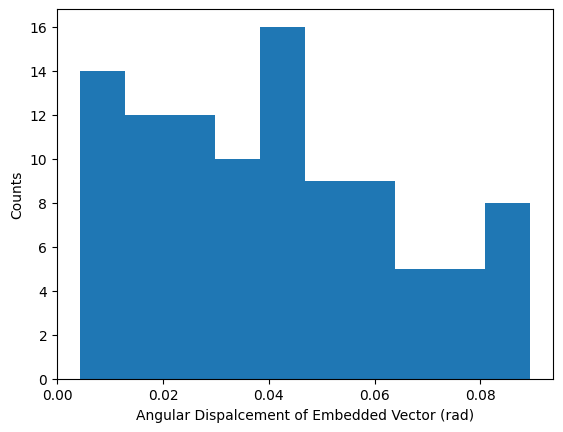

In [12]:
fig, ax = plt.subplots()
ax.hist(embedding_angle_shifts)
ax.set_xlabel("Angular Dispalcement of Embedded Vector (rad)")
ax.set_ylabel("Counts")

We can see that the embedding vector is only displaced slightly when completely random phases are supplied to the non-primary dimensions.

We can also check that the returned decoder produces the right phases compared to ground truth values,

In [17]:
with torch.no_grad():
    decoded_angles = decoder(torch.tensor(ring_embedded_points, dtype=torch.get_default_dtype()).to(device))

predicted_phases = torch.squeeze(decoded_angles).cpu().numpy()[:, used_dimension]


In [18]:
def compare_to_ground_truth(predicted_phases, ground_truth_phases, plot_ax):
    refd_test_phases = geometry_util.reference_periodic_phases(predicted_phases)
    refd_true_phases = geometry_util.reference_periodic_phases(ground_truth_phases)
    line = np.arange(start=-np.pi, stop=np.pi, step=0.01)
    plot_ax.scatter(refd_true_phases, refd_test_phases)
    plot_ax.plot(line, line, color="black", linestyle="--", label="y=x")
    plot_ax.set_xlabel("True Phase")
    plot_ax.set_ylabel("Found Phase")
    return refd_test_phases, refd_true_phases


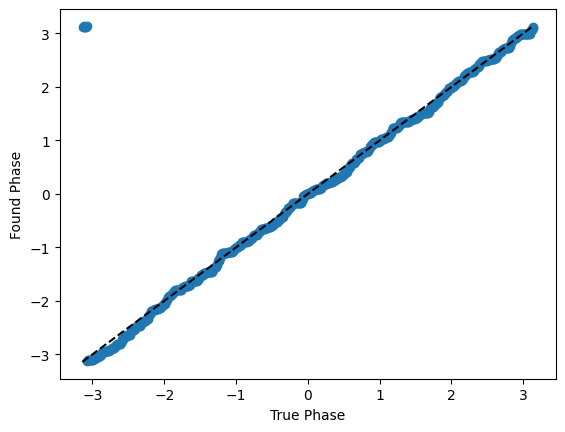

In [19]:
%matplotlib inline
fig, ax = plt.subplots()
refd_predicted_phases, refd_true_phases = compare_to_ground_truth(predicted_phases, angles, ax)
